In [143]:
 import tensorflow as tf
 import numpy as np
 import matplotlib.pyplot as plt
 import tensorflow_datasets as tfds
 import cv2
 import tensorflow_probability as tfp

 from tensorflow.keras.layers import Resizing,Rescaling,InputLayer, Dense, Conv2D,MaxPooling2D, MaxPool2D, Flatten, BatchNormalization, Input, Dropout, GlobalAveragePooling2D
 from tensorflow.keras.layers import Add, Activation, RandomRotation,RandomFlip,RandomContrast
 from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
 from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy
 from tensorflow.keras.optimizers import Adam
 from tensorflow.keras.models import Model
 from tensorflow.keras.layers import Layer
 from tensorflow.keras.regularizers import L2,L1

 from tensorflow.train import BytesList, FloatList, Int64List
 from tensorflow.train import Example, Features, Feature
 import sklearn
 from sklearn.metrics import confusion_matrix, roc_curve
 import seaborn as sns

 from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

**Data Downloading**

In [2]:
# install kaggle to download the dataset from kaggle
!pip install -q kaggle

In [3]:
# kaggle.json is a api token used to give access to the user
# store the kaggle.json file in ~/.kaggle directory to allow the use of api token
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [4]:
# Give user the full right to read and write into the aggle file
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
#download the dataset fro kaggle
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 99% 307M/309M [00:17<00:00, 19.9MB/s]
100% 309M/309M [00:17<00:00, 18.6MB/s]


In [6]:
# Unzip the data and save into a dataset folder
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

**Data Loading**

In [180]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

CLASS_NAMES = ["angry", "happy", "sad"]

# Dictionary "Configuration" describing the parameters for the model
Configuration = {
    "Batch_size" : 32,
    "Im_size"    : 256,
    "learning_rate" : 0.001,
    "n_epochs" : 50,
    "dropout_rate" : 0.0,
    "regularization_rate" : 0.0,
    "n_filters" : 6,
    "kernel_size": 3,
    "n_strides": 1,
    "pool_size":2,
    "n_dense_1": 100,
    "n_dense_2": 10,
    "num_classes": 3,
}

In [181]:
# using keras.utils create a train_dataset from the directory
# The class_names must match the names of the sub-folders of each class
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=Configuration["Batch_size"],
    image_size=(Configuration["Im_size"], Configuration["Im_size"]),
    shuffle=True,
    seed=99,


)

Found 6799 files belonging to 3 classes.


In [182]:
#Creating a validation dataset
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=Configuration["Batch_size"],
    image_size=(Configuration["Im_size"], Configuration["Im_size"]),
    shuffle=True,
    seed=99,


)

Found 2278 files belonging to 3 classes.


In [ ]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

**Dataset Visualization**

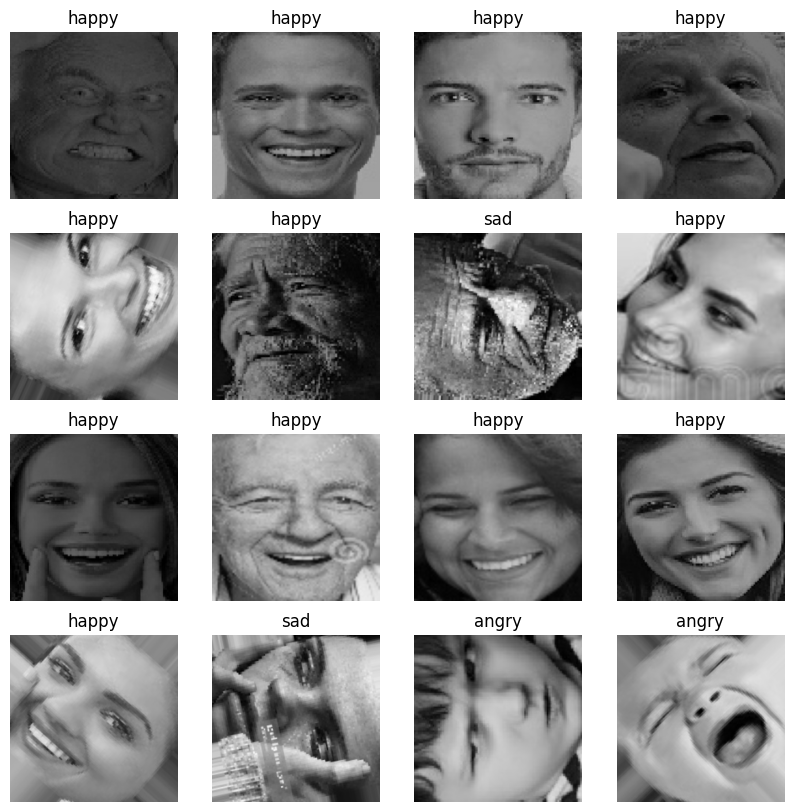

In [ ]:
plt.figure(figsize = (10,10))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.0)
    plt.title(CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")


**Data augmentation**

In [183]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (-0.025,0.025)),
    RandomFlip(mode = 'horizontal'),
    RandomContrast(factor = 0.1),

])

In [184]:
def augment_layer(image,label):
  return augment_layers(image, training=True), label



In [185]:
def resizing_rescale_images(image, label):
  return tf.image.resize(image, (Configuration["Im_size"], Configuration["Im_size"]))/255.0, label
train_dataset = train_dataset.map(resizing_rescale_images)


In [186]:
val_dataset = val_dataset.map(resizing_rescale_images)

**Data Preparation**

In [187]:
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
    )

In [188]:
validation_dataset = (val_dataset.prefetch(tf.data.AUTOTUNE)
                      )

**TFRecords**

TFREcords provides a way to create an efficient data pipeline and ensures efficient training of the model. The conventional tf.dataset needs to be preprocessed and augmented everytime a model needs training. However, that process is redundant and produces the same results each time. To avoid that, data is preprocessed and augmented and stored as TFRecord consisting of  predefined shards or packs. These TFRecord shards then can be used directly to train the model whenever you need without having to preprocess the data everytime a new training is carried out.

In order to create TFRecords, we need unbatched data.The next step is to create example that stores in the features present in the dataset. For example, in the dataset used here, we have images as input and labels as output. Therefore, the features are images and labels. To finally create the record consisting of different number of shards, tf.io.TFRecordWriter method is used.

In [18]:
! mkdir ~/tfrecords

mkdir: cannot create directory ‘/root/tfrecords’: File exists


In [ ]:
# First unbatch the dataset
training_dataset = (
    training_dataset
    .unbatch()
)

In [ ]:
validation_dataset=(
    validation_dataset
    .unbatch()
    )

In [ ]:
# Create example file consisting of key-value pair
def create_example(image, label):

  # tensorflow.train.Feature provides 3 datatypes in which the features can be stored.
  #I am using Byteslist for images and Int64List for labels
  bytes_feature = Feature(
      bytes_list=BytesList(value=[image]))

  int_feature = Feature(
      int64_list=Int64List(value=[tf.argmax(label, axis = 0)]))


  #  tensorflow.train.Example helps in creating the key-value pair where each key maps to a feature of the dataset
  example = Example(
      features=Features(feature={
          'my_bytes': bytes_feature,
          'my_ints': int_feature,

      }))
  return example.SerializeToString()

In [19]:
num_shards = 10
path = "tfrecords/shard_{:02d}.tfrecord"

In [ ]:
# Function that encodes image into bytes and uint8 datatype to match the features in example in create_example
def encode_image(image, label):
  image = tf.image.convert_image_dtype(image, dtype = tf.uint8)
  image = tf.io.encode_jpeg(image)
  return image,label

In [ ]:
#create encoded dataset for entire training dataset by mapping the encode_image function
encoded_dataset =  (
    training_dataset.map(encode_image)
)

In [ ]:
# Write the records to a file.
for shard_number in range(num_shards):

  sharded_dataset = (
      encoded_dataset
      .shard(num_shards, shard_number)
      .as_numpy_iterator()
  )

  with tf.io.TFRecordWriter(path.format(shard_number)) as file_writer:
    for encoded_image,encoded_label in sharded_dataset:
      example = create_example(encoded_image, encoded_label)
      file_writer.write(example)

**Convert tfrecord to tf dataset**

In [ ]:
record_dataset = tf.data.TFRecordDataset(filenames = [path.format(p) for p in range(num_shards)])

In [ ]:
def parse_tfrecords(example):

  feature_description = {
      "my_bytes" : tf.io.FixedLenFeature([], tf.string),
      "my_ints" : tf.io.FixedLenFeature([], tf.int64)
  }

  example = tf.io.parse_single_example(example, feature_description)
  example["my_bytes"] = tf.io.decode_jpeg(example["my_bytes"], channels = 3)

  return example["my_bytes"], example["my_ints"]

In [ ]:
parsed_dataset = (
    record_dataset.map(parse_tfrecords)
    .batch(Configuration["Batch_size"])
    .prefetch(tf.data.AUTOTUNE)
)

resize and rescale layer inside the model so that it offers easier model deployment without the need for user to do it themselves.

In [20]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(Configuration["Im_size"], Configuration["Im_size"]),
    Rescaling(1./255.),
])

**Modeling**

In [ ]:
model= tf.keras.Sequential([
        InputLayer(input_shape = (None, None,3)),
        resize_rescale_layers ,


        Conv2D(filters=Configuration["n_filters"], kernel_size = Configuration["kernel_size"],
               strides=Configuration["n_strides"], padding='valid', activation='relu',
               kernel_regularizer = L2(Configuration["regularization_rate"])),
        BatchNormalization(),
        MaxPool2D(pool_size = Configuration["pool_size"], strides=Configuration["n_strides"]*2),
        Dropout(rate= Configuration["dropout_rate"]),

        Conv2D(Configuration["n_filters"]*2+4, kernel_size =Configuration["kernel_size"],
               strides=Configuration["n_strides"], padding='valid', activation='relu',
              kernel_regularizer = L2(Configuration["regularization_rate"])),
        BatchNormalization(),
        MaxPool2D(pool_size =Configuration["pool_size"], strides=Configuration["n_strides"]*2),

        Conv2D(Configuration["n_filters"]*2, kernel_size =Configuration["kernel_size"],
               strides=Configuration["n_strides"], padding='valid', activation='relu',
              kernel_regularizer = L2(Configuration["regularization_rate"])),
        BatchNormalization(),
        MaxPool2D(pool_size =Configuration["pool_size"], strides=Configuration["n_strides"]*2),




        Flatten(),

        Dense(Configuration["n_dense_1"],activation='relu', kernel_regularizer = L2(Configuration["regularization_rate"])),
        BatchNormalization(),
        Dropout(rate= Configuration["dropout_rate"]),

        Dense(Configuration["n_dense_2"], activation='relu', kernel_regularizer = L2(Configuration["regularization_rate"])),
        BatchNormalization(),


        Dense(Configuration["num_classes"], activation='softmax'), ])

model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_16 (Bat  (None, 254, 254, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 127, 127, 6)      0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 16)     

**ResNet 34 using model subclassing method**


The ResNet 34 model introduces residual blocks within its structure to solve the bottleneck of limited number of layers as suggested by VGGNet model. According to the VGGNet model, after a certain number of Convolution layers, the performance of the model deteriorates. This limitation is solved by ResNet model by introducing residual blocks to overcome the vanishing gradient problem and also the introduction of Batch Normalization to solve the internal covariant shift. The introduction of ResNet model allowed a deeper model which would result in improvement of the performance with incresing depth of layers.    

**CustomConv2D Layer**

In [69]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__()

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding
    )

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x

**Residual Block**

In [70]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, strides =1):
    super(ResidualBlock, self).__init__(name = 'residual_block')

    self.dotted = (strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, strides, padding = 'same')
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = 'same')

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, strides)


  def call(self, input, training):
    x =self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training)
      x_add = Add()([x, x_add])

    else:
      x_add = Add()([x, input])

    return self.activation(x_add)

**Entire Network**

In [55]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet-34')

    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128,2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256,2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512,2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc = Dense(Configuration["num_classes"], activation = 'softmax')


  def call(self,x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)

    x =self.conv_3_1(x, training)
    x =self.conv_3_2(x, training)
    x =self.conv_3_3(x, training)
    x =self.conv_3_4(x, training)

    x =self.conv_4_1(x, training)
    x =self.conv_4_2(x, training)
    x =self.conv_4_3(x, training)
    x =self.conv_4_4(x, training)
    x =self.conv_4_5(x, training)
    x =self.conv_4_6(x, training)

    x =self.conv_5_1(x, training)
    x =self.conv_5_2(x, training)
    x =self.conv_5_3(x, training)

    x = self.global_pool(x)

    return self.fc(x)



In [71]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,256,256,3]), training = True)
resnet_34.summary()


Model: "resnet-34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d_108 (CustomCo  multiple                 9728      
 nv2D)                                                           
                                                                 
 max_pooling2d_3 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 residual_block (ResidualBlo  multiple                 74368     
 ck)                                                             
                                                                 
 residual_block (ResidualBlo  multiple                 74368     
 ck)                                                             
                                                                 
 residual_block (ResidualBlo  multiple                 74

**Training**

In [73]:
# Model Checkpoint to monitor the best weights obtained during training the model
checkpoint_callback = ModelCheckpoint(
    'best_weights',
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1,
    save_best_only = True,
)

# ReduceLROnPlateu to monitor validation accuracy and decrease the learning rate by a defined factor
# in case 5 consecutive epoch shows no improvement in val_accuracy
reduce_lr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=5, min_lr=0.001)

In [74]:
# CategoricalCrossentropy takes care of the labels in categorical form
loss = CategoricalCrossentropy()

In [75]:

metrics = [CategoricalAccuracy(name = 'accuracy'), TopKCategoricalAccuracy(k=2,name = 'top_k_categorical')]

In [76]:
# Compiling the model
resnet_34.compile(
    optimizer = Adam(learning_rate = Configuration["learning_rate"]*10 ),
    loss = loss,
    metrics = metrics
)

In [77]:
# Training the model
history = resnet_34.fit(training_dataset, validation_data = validation_dataset, epochs = Configuration["n_epochs"], verbose=1, callbacks = [checkpoint_callback, reduce_lr_callback,] )

Epoch 1/50
213/213 [==============================] - ETA: 0s - loss: 1.5794 - accuracy: 0.4161 - top_k_categorical: 0.7220
Epoch 1: val_accuracy improved from -inf to 0.45127, saving model to best_weights


213/213 [==============================] - 136s 402ms/step - loss: 1.5794 - accuracy: 0.4161 - top_k_categorical: 0.7220 - val_loss: 50.7613 - val_accuracy: 0.4513 - val_top_k_categorical: 0.7932 - lr: 0.0100
Epoch 2/50
213/213 [==============================] - ETA: 0s - loss: 1.1196 - accuracy: 0.4876 - top_k_categorical: 0.7641
Epoch 2: val_accuracy improved from 0.45127 to 0.48990, saving model to best_weights


213/213 [==============================] - 85s 396ms/step - loss: 1.1196 - accuracy: 0.4876 - top_k_categorical: 0.7641 - val_loss: 1.0618 - val_accuracy: 0.4899 - val_top_k_categorical: 0.7445 - lr: 0.0100
Epoch 3/50
213/213 [==============================] - ETA: 0s - loss: 1.0332 - accuracy: 0.5120 - top_k_categorical: 0.7957
Epoch 3: val_accuracy did not improve from 0.48990
213/213 [==============================] - 65s 300ms/step - loss: 1.0332 - accuracy: 0.5120 - top_k_categorical: 0.7957 - val_loss: 1.2414 - val_accuracy: 0.4614 - val_top_k_categorical: 0.7818 - lr: 0.0100
Epoch 4/50
213/213 [==============================] - ETA: 0s - loss: 0.9720 - accuracy: 0.5417 - top_k_categorical: 0.8111
Epoch 4: val_accuracy improved from 0.48990 to 0.49912, saving model to best_weights


213/213 [==============================] - 86s 401ms/step - loss: 0.9720 - accuracy: 0.5417 - top_k_categorical: 0.8111 - val_loss: 1.1716 - val_accuracy: 0.4991 - val_top_k_categorical: 0.7818 - lr: 0.0100
Epoch 5/50
213/213 [==============================] - ETA: 0s - loss: 0.9471 - accuracy: 0.5613 - top_k_categorical: 0.8250
Epoch 5: val_accuracy did not improve from 0.49912
213/213 [==============================] - 67s 312ms/step - loss: 0.9471 - accuracy: 0.5613 - top_k_categorical: 0.8250 - val_loss: 1.2761 - val_accuracy: 0.4960 - val_top_k_categorical: 0.7537 - lr: 0.0100
Epoch 6/50
213/213 [==============================] - ETA: 0s - loss: 0.9162 - accuracy: 0.5701 - top_k_categorical: 0.8303
Epoch 6: val_accuracy improved from 0.49912 to 0.58077, saving model to best_weights


213/213 [==============================] - 89s 415ms/step - loss: 0.9162 - accuracy: 0.5701 - top_k_categorical: 0.8303 - val_loss: 0.9347 - val_accuracy: 0.5808 - val_top_k_categorical: 0.8266 - lr: 0.0100
Epoch 7/50
213/213 [==============================] - ETA: 0s - loss: 0.8606 - accuracy: 0.6066 - top_k_categorical: 0.8520
Epoch 7: val_accuracy improved from 0.58077 to 0.59614, saving model to best_weights


213/213 [==============================] - 84s 394ms/step - loss: 0.8606 - accuracy: 0.6066 - top_k_categorical: 0.8520 - val_loss: 0.9204 - val_accuracy: 0.5961 - val_top_k_categorical: 0.8402 - lr: 0.0100
Epoch 8/50
213/213 [==============================] - ETA: 0s - loss: 0.8211 - accuracy: 0.6239 - top_k_categorical: 0.8566
Epoch 8: val_accuracy did not improve from 0.59614
213/213 [==============================] - 66s 305ms/step - loss: 0.8211 - accuracy: 0.6239 - top_k_categorical: 0.8566 - val_loss: 1.5676 - val_accuracy: 0.5000 - val_top_k_categorical: 0.7695 - lr: 0.0100
Epoch 9/50
213/213 [==============================] - ETA: 0s - loss: 0.7864 - accuracy: 0.6466 - top_k_categorical: 0.8692
Epoch 9: val_accuracy did not improve from 0.59614
213/213 [==============================] - 68s 314ms/step - loss: 0.7864 - accuracy: 0.6466 - top_k_categorical: 0.8692 - val_loss: 1.2402 - val_accuracy: 0.4113 - val_top_k_categorical: 0.7401 - lr: 0.0100
Epoch 10/50
213/213 [========

213/213 [==============================] - 91s 426ms/step - loss: 0.6887 - accuracy: 0.6976 - top_k_categorical: 0.8970 - val_loss: 0.8589 - val_accuracy: 0.6286 - val_top_k_categorical: 0.8736 - lr: 0.0100
Epoch 13/50
213/213 [==============================] - ETA: 0s - loss: 0.6664 - accuracy: 0.7057 - top_k_categorical: 0.9045
Epoch 13: val_accuracy did not improve from 0.62862
213/213 [==============================] - 69s 321ms/step - loss: 0.6664 - accuracy: 0.7057 - top_k_categorical: 0.9045 - val_loss: 0.8033 - val_accuracy: 0.6234 - val_top_k_categorical: 0.8521 - lr: 0.0100
Epoch 14/50
213/213 [==============================] - ETA: 0s - loss: 0.6377 - accuracy: 0.7251 - top_k_categorical: 0.9066
Epoch 14: val_accuracy did not improve from 0.62862
213/213 [==============================] - 63s 294ms/step - loss: 0.6377 - accuracy: 0.7251 - top_k_categorical: 0.9066 - val_loss: 0.8889 - val_accuracy: 0.6071 - val_top_k_categorical: 0.8341 - lr: 0.0100
Epoch 15/50
213/213 [====

213/213 [==============================] - 86s 402ms/step - loss: 0.4629 - accuracy: 0.8076 - top_k_categorical: 0.9471 - val_loss: 0.5358 - val_accuracy: 0.7713 - val_top_k_categorical: 0.9328 - lr: 0.0020
Epoch 19/50
213/213 [==============================] - ETA: 0s - loss: 0.4179 - accuracy: 0.8278 - top_k_categorical: 0.9522
Epoch 19: val_accuracy did not improve from 0.77129
213/213 [==============================] - 63s 292ms/step - loss: 0.4179 - accuracy: 0.8278 - top_k_categorical: 0.9522 - val_loss: 0.6063 - val_accuracy: 0.7388 - val_top_k_categorical: 0.9219 - lr: 0.0020
Epoch 20/50
213/213 [==============================] - ETA: 0s - loss: 0.3982 - accuracy: 0.8387 - top_k_categorical: 0.9528
Epoch 20: val_accuracy improved from 0.77129 to 0.77700, saving model to best_weights


213/213 [==============================] - 87s 404ms/step - loss: 0.3982 - accuracy: 0.8387 - top_k_categorical: 0.9528 - val_loss: 0.5269 - val_accuracy: 0.7770 - val_top_k_categorical: 0.9381 - lr: 0.0020
Epoch 21/50
213/213 [==============================] - ETA: 0s - loss: 0.3667 - accuracy: 0.8504 - top_k_categorical: 0.9603
Epoch 21: val_accuracy improved from 0.77700 to 0.78797, saving model to best_weights


213/213 [==============================] - 92s 431ms/step - loss: 0.3667 - accuracy: 0.8504 - top_k_categorical: 0.9603 - val_loss: 0.5534 - val_accuracy: 0.7880 - val_top_k_categorical: 0.9394 - lr: 0.0020
Epoch 22/50
213/213 [==============================] - ETA: 0s - loss: 0.3497 - accuracy: 0.8575 - top_k_categorical: 0.9619
Epoch 22: val_accuracy did not improve from 0.78797
213/213 [==============================] - 63s 295ms/step - loss: 0.3497 - accuracy: 0.8575 - top_k_categorical: 0.9619 - val_loss: 0.5449 - val_accuracy: 0.7827 - val_top_k_categorical: 0.9350 - lr: 0.0020
Epoch 23/50
213/213 [==============================] - ETA: 0s - loss: 0.3421 - accuracy: 0.8635 - top_k_categorical: 0.9628
Epoch 23: val_accuracy did not improve from 0.78797
213/213 [==============================] - 66s 308ms/step - loss: 0.3421 - accuracy: 0.8635 - top_k_categorical: 0.9628 - val_loss: 0.6155 - val_accuracy: 0.7840 - val_top_k_categorical: 0.9284 - lr: 0.0020
Epoch 24/50
213/213 [====

213/213 [==============================] - 92s 428ms/step - loss: 0.3244 - accuracy: 0.8685 - top_k_categorical: 0.9665 - val_loss: 0.5530 - val_accuracy: 0.7906 - val_top_k_categorical: 0.9355 - lr: 0.0020
Epoch 25/50
213/213 [==============================] - ETA: 0s - loss: 0.3138 - accuracy: 0.8762 - top_k_categorical: 0.9679
Epoch 25: val_accuracy did not improve from 0.79061
213/213 [==============================] - 65s 302ms/step - loss: 0.3138 - accuracy: 0.8762 - top_k_categorical: 0.9679 - val_loss: 1.0613 - val_accuracy: 0.7577 - val_top_k_categorical: 0.9166 - lr: 0.0020
Epoch 26/50
213/213 [==============================] - ETA: 0s - loss: 0.2963 - accuracy: 0.8807 - top_k_categorical: 0.9718
Epoch 26: val_accuracy did not improve from 0.79061
213/213 [==============================] - 68s 317ms/step - loss: 0.2963 - accuracy: 0.8807 - top_k_categorical: 0.9718 - val_loss: 0.5919 - val_accuracy: 0.7669 - val_top_k_categorical: 0.9267 - lr: 0.0020
Epoch 27/50
213/213 [====

213/213 [==============================] - 87s 403ms/step - loss: 0.2646 - accuracy: 0.8920 - top_k_categorical: 0.9757 - val_loss: 0.5156 - val_accuracy: 0.8156 - val_top_k_categorical: 0.9456 - lr: 0.0020
Epoch 29/50
213/213 [==============================] - ETA: 0s - loss: 0.2587 - accuracy: 0.9001 - top_k_categorical: 0.9781
Epoch 29: val_accuracy did not improve from 0.81563
213/213 [==============================] - 63s 291ms/step - loss: 0.2587 - accuracy: 0.9001 - top_k_categorical: 0.9781 - val_loss: 0.5794 - val_accuracy: 0.8007 - val_top_k_categorical: 0.9429 - lr: 0.0020
Epoch 30/50
213/213 [==============================] - ETA: 0s - loss: 0.2400 - accuracy: 0.9056 - top_k_categorical: 0.9784
Epoch 30: val_accuracy did not improve from 0.81563
213/213 [==============================] - 65s 299ms/step - loss: 0.2400 - accuracy: 0.9056 - top_k_categorical: 0.9784 - val_loss: 0.5357 - val_accuracy: 0.8038 - val_top_k_categorical: 0.9390 - lr: 0.0020
Epoch 31/50
213/213 [====

213/213 [==============================] - 87s 404ms/step - loss: 0.1466 - accuracy: 0.9425 - top_k_categorical: 0.9918 - val_loss: 0.5905 - val_accuracy: 0.8205 - val_top_k_categorical: 0.9442 - lr: 0.0010
Epoch 36/50
213/213 [==============================] - ETA: 0s - loss: 0.1371 - accuracy: 0.9460 - top_k_categorical: 0.9922
Epoch 36: val_accuracy improved from 0.82046 to 0.82792, saving model to best_weights


213/213 [==============================] - 92s 428ms/step - loss: 0.1371 - accuracy: 0.9460 - top_k_categorical: 0.9922 - val_loss: 0.6380 - val_accuracy: 0.8279 - val_top_k_categorical: 0.9508 - lr: 0.0010
Epoch 37/50
213/213 [==============================] - ETA: 0s - loss: 0.1328 - accuracy: 0.9523 - top_k_categorical: 0.9932
Epoch 37: val_accuracy improved from 0.82792 to 0.83889, saving model to best_weights


213/213 [==============================] - 84s 390ms/step - loss: 0.1328 - accuracy: 0.9523 - top_k_categorical: 0.9932 - val_loss: 0.5702 - val_accuracy: 0.8389 - val_top_k_categorical: 0.9517 - lr: 0.0010
Epoch 38/50
213/213 [==============================] - ETA: 0s - loss: 0.1373 - accuracy: 0.9463 - top_k_categorical: 0.9903
Epoch 38: val_accuracy did not improve from 0.83889
213/213 [==============================] - 68s 315ms/step - loss: 0.1373 - accuracy: 0.9463 - top_k_categorical: 0.9903 - val_loss: 0.8101 - val_accuracy: 0.7946 - val_top_k_categorical: 0.9412 - lr: 0.0010
Epoch 39/50
213/213 [==============================] - ETA: 0s - loss: 0.1173 - accuracy: 0.9556 - top_k_categorical: 0.9924
Epoch 39: val_accuracy did not improve from 0.83889
213/213 [==============================] - 64s 295ms/step - loss: 0.1173 - accuracy: 0.9556 - top_k_categorical: 0.9924 - val_loss: 0.7833 - val_accuracy: 0.8055 - val_top_k_categorical: 0.9451 - lr: 0.0010
Epoch 40/50
213/213 [====

213/213 [==============================] - 86s 401ms/step - loss: 0.1169 - accuracy: 0.9547 - top_k_categorical: 0.9928 - val_loss: 0.5870 - val_accuracy: 0.8433 - val_top_k_categorical: 0.9570 - lr: 0.0010
Epoch 44/50
213/213 [==============================] - ETA: 0s - loss: 0.1175 - accuracy: 0.9573 - top_k_categorical: 0.9941
Epoch 44: val_accuracy did not improve from 0.84328
213/213 [==============================] - 63s 292ms/step - loss: 0.1175 - accuracy: 0.9573 - top_k_categorical: 0.9941 - val_loss: 0.9106 - val_accuracy: 0.7722 - val_top_k_categorical: 0.9346 - lr: 0.0010
Epoch 45/50
213/213 [==============================] - ETA: 0s - loss: 0.1101 - accuracy: 0.9576 - top_k_categorical: 0.9950
Epoch 45: val_accuracy did not improve from 0.84328
213/213 [==============================] - 65s 303ms/step - loss: 0.1101 - accuracy: 0.9576 - top_k_categorical: 0.9950 - val_loss: 0.7008 - val_accuracy: 0.8191 - val_top_k_categorical: 0.9447 - lr: 0.0010
Epoch 46/50
213/213 [====

**Visualization of model loss and performance vs number of epochs**

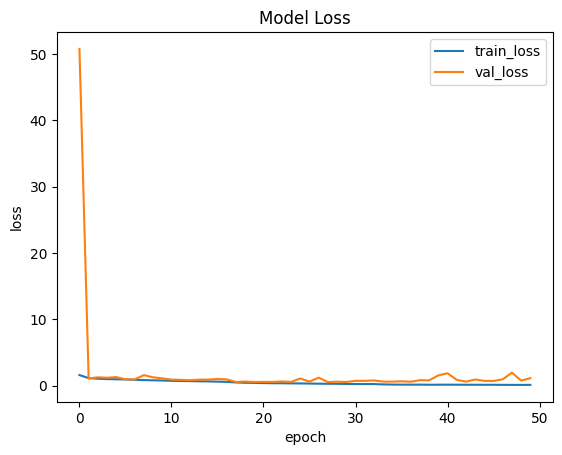

In [78]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

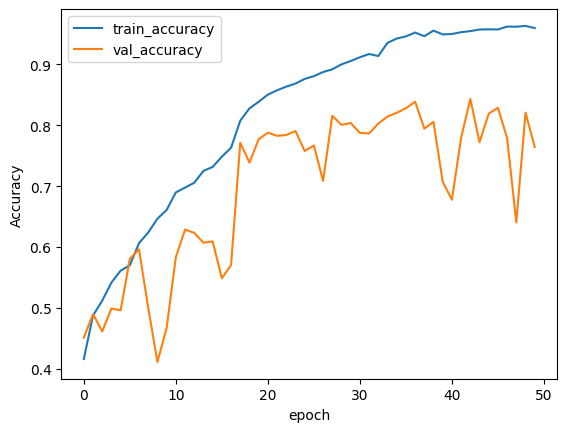

In [79]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

**Evaluation**

In [189]:
#Load the best weights of the trained model
resnet_34.load_weights('best_weights')

In [190]:
#model evaluation
resnet_34.evaluate(validation_dataset)

72/72 [==============================] - 5s 69ms/step - loss: 0.5870 - accuracy: 0.8433 - top_k_categorical: 0.9570


[0.5870179533958435, 0.8432835936546326, 0.9569798111915588]

In [198]:
validation_dataset.take(1)



<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

**Testing**

In [197]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/104709.jpg_brightness_2.jpg")

im = tf.constant(test_image, dtype=tf.float32)
im = tf.expand_dims(im, axis = 0)

print(CLASS_NAMES[tf.argmax(resnet_34.predict(im), axis=-1).numpy()[0]])


1/1 [==============================] - 0s 36ms/step
sad


1/1 [==============================] - 0s 49ms/step


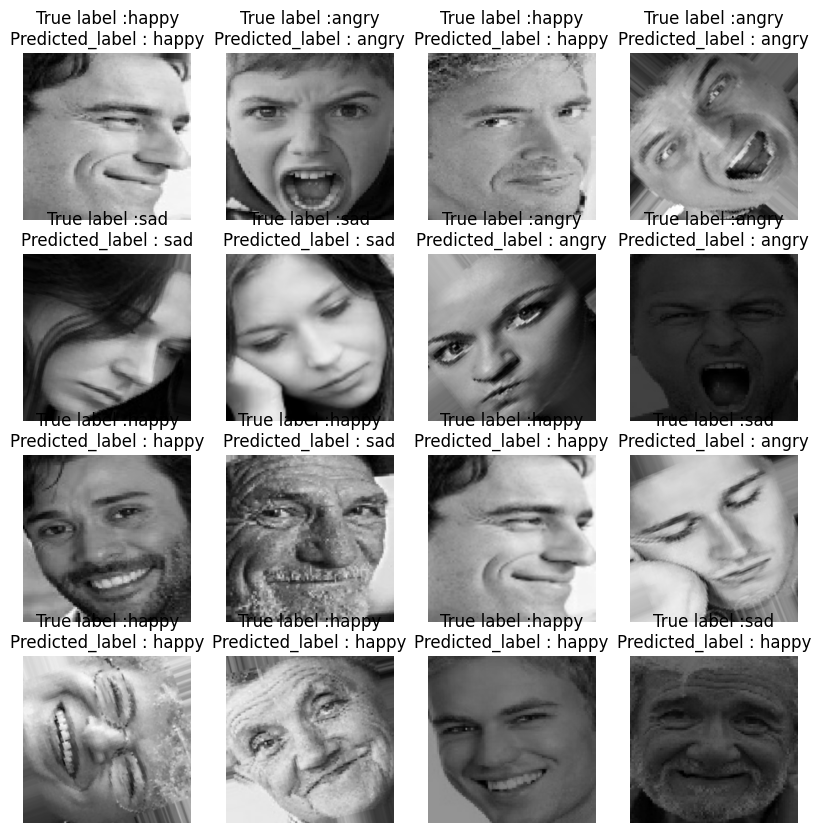

In [196]:
# Visualizing the predicted vs true labels of images
plt.figure(figsize = (10,10))

for image, labels in validation_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(image[i])
    plt.title("True label :" + CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()]
              + "\n" + "Predicted_label : "+ CLASS_NAMES[tf.argmax(resnet_34.predict(tf.expand_dims(image[i], axis=0)), axis = -1).numpy()[0]] )
    plt.axis("off")

**Confusion Matrix**

In [111]:
predicted = []
true = []
for im, label in validation_dataset:
  predicted.append(resnet_34(im))
  true.append(label)


In [ ]:

print(np.argmax(true[:-1], axis = -1).flatten())

[2 1 1 ... 2 1 1]


In [112]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(),np.argmax(predicted[-1], axis = -1).flatten()])
true_label = np.concatenate([np.argmax(true[:-1], axis = -1).flatten(), np.argmax(true[-1], axis = -1).flatten()])

[[401  34  80]
 [ 41 887  78]
 [ 65  69 623]]


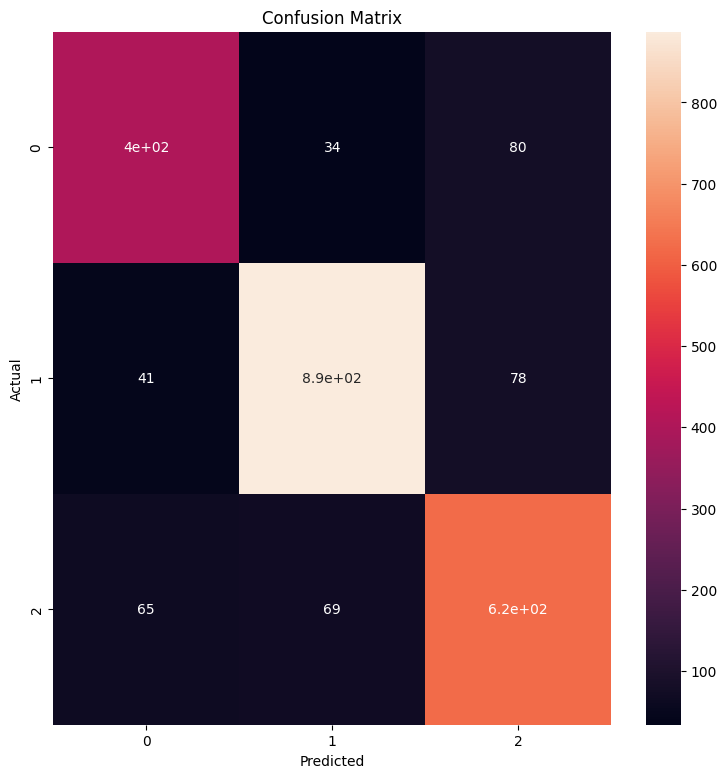

In [113]:
cm = confusion_matrix(true_label,pred)
print(cm)
plt.figure(figsize = (9,9))
sns.heatmap(cm, annot = True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()